# TODO LIST
* Standardise the sale price
* Split df_addData into the test/train sets again
* Account for the SalePrice somehow?

Useful links:
* https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python
* https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard
* https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition

## Library imports, data imports, and initialisations

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

import warnings
warnings.filterwarnings('ignore')

from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, probplot, skew
from sklearn.preprocessing import StandardScaler

## Load in datasets
Read the CSV files for the training and testing data, then create a concatenated version for feature engineering.

In [173]:
# Load in the training and testing datasets
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Save and remove the ID columns
trainingIDs = df_train['Id']
testingIDs = df_test['Id']

df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

# Combine the datasets
df_allData = pd.concat([df_train, df_test]).reset_index(drop = True)
df_allData.drop(['SalePrice'], axis = 1, inplace = True)

## Impute missing values
I've chosen to do this first, so that any effects it has on relationships or other aspects of this exploration/modeling can be accounted for early on.

In [174]:
def getMissingValues():
    missingValuesTotal = df_allData.isnull().sum().sort_values(ascending = False)
    missingValuesPercent = (100 * df_allData.isnull().sum() / df_allData.isnull().count()).sort_values(ascending = False)

    missingValues = pd.concat([missingValuesTotal, missingValuesPercent], axis = 1, keys = ['# Missing', '% Missing'])
    return missingValues[missingValues['# Missing'] > 0]

getMissingValues()

,# Missing,% Missing
PoolQC,2909,99.657
MiscFeature,2814,96.403
Alley,2721,93.217
Fence,2348,80.439
FireplaceQu,1420,48.647
LotFrontage,486,16.650
GarageYrBlt,159,5.447
GarageFinish,159,5.447
GarageQual,159,5.447
GarageCond,159,5.447


In [175]:
# For each of the following characteristics, data_description.txt notes that NaN values are equivalent to having none of the corresponding characteristic
for var in ['Alley', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'Fence', 'FireplaceQu', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'MasVnrType', 'MiscFeature', 'PoolQC']:
    df_allData[var] = df_allData[var].fillna('NA')

# For each of the following characteristics, data_description.txt notes that NaN values are equivalent to having a zero-quantity of the corresponding characteristic
for var in ['GarageYrBlt', 'MasVnrArea']:
    df_allData[var] = df_allData[var].fillna(0)
    
# In data_description.txt, no substitution is given for NaN LotFrontage characteristics;  thus I'm going to assume they should be zero-quantity values.
for var in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'GarageArea', 'GarageCars', 'TotalBsmtSF']:
    df_allData[var] = df_allData[var].fillna(0)
    
# In data_description.txt, no substitution is given for NaN LotFrontage characteristics; thus I'm going to use the median values for the row's corresponding neighbourhood.
# This may have issues when a there is a NaN value in a neighbourhood with no other samples, but for now this is not the case.
df_allData['LotFrontage'] = df_allData.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    
# For each of the following characteristics, data_description.txt gives no substitution options for NaN values (and there are no equivalent 'N/A' options); thus I will be assigning the 'standard/base' value.
df_allData['Electrical'] = df_allData['Electrical'].fillna('SBrkr')
df_allData['Functional'] = df_allData['Functional'].fillna('Typ')
df_allData['KitchenQual'] = df_allData['KitchenQual'].fillna('TA')

# For each of the following characteristics, data_description.txt gives no substitution options for NaN values (and there are no equivalent 'N/A' options), and there are no standard/base values; thus I will be assigning mode for each characteristic.
for var in ['Exterior1st', 'Exterior2nd', 'MSZoning', 'SaleType', 'Utilities']:
    df_allData[var] = df_allData[var].fillna(df_allData[var].mode()[0])

# Confirm that all missing values have been fixed
getMissingValues()

,# Missing,% Missing


## Clean data types
Change all categorical columns are as noted as numbers to strings.

In [176]:
cols_numToObj = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt',
                 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']

for col in cols_numToObj:
    df_train[col] = df_train[col].apply(str)
    df_test[col] = df_test[col].apply(str)
    df_allData[col] = df_allData[col].apply(str)

## Preliminary correlation inspections
Review correlation values between each set of characteristics, to identify if there are any redundant columns that could be dropped.

Characteristics with significant correlations:
GarageArea    GarageCars    0.882
TotRmsAbvGrd  GrLivArea     0.825
1stFlrSF      TotalBsmtSF   0.820
dtype: float64



<AxesSubplot:>

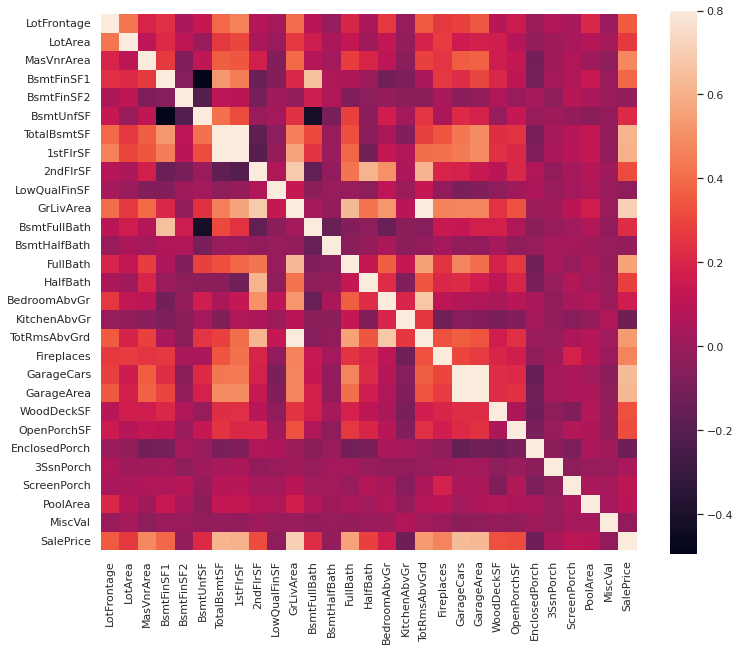

In [177]:
# Correlation matrix for all characteristics
corrMat = df_train.corr()

# Determine which correlations are significant, and drop the others
# Assuming correlation values >= 0.8 are significant
corrValues = corrMat.unstack().abs()
c = [corrValues.drop(i, inplace = True) for i, v in corrValues.items()
     if i[0] == i[1]                           # left and right index are the same
     or v < 0.8                                # Value is insignificant
     or (i[1], i[0]) in corrValues.index]      # repeated correlation values

# Sort and print the correlation values
print('Characteristics with significant correlations:\n{}\n'.format(corrValues.sort_values(ascending = False)))

# Print the figure
sns.set(font_scale = 1.0, rc = {'figure.figsize': (12, 10)})
sns.heatmap(corrMat, vmax = 0.8, square = True)

Very strong correlations between the following:
* GarageArea & GarageCars
* TotRmsAbvGrd & GrLivArea
* 1stFlrSF & TotalBsmtSF

I'll check which characteristic in each of the above pairs has a stronger correlation with SalePrice, and remove the other column.

Characteristics with correlation values over 0.5:
GrLivArea      0.709
GarageCars     0.640
GarageArea     0.623
TotalBsmtSF    0.614
1stFlrSF       0.606
FullBath       0.561
TotRmsAbvGrd   0.534
Name: SalePrice, dtype: float64



<AxesSubplot:>

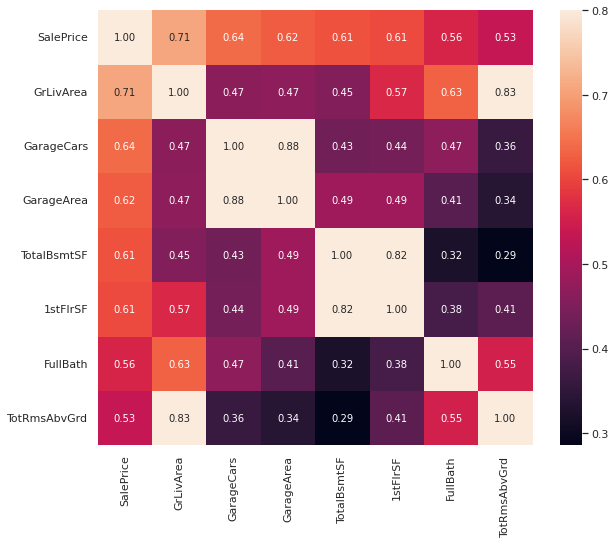

In [178]:
# Saleprice correlation matrix
#     Only including characteristics with correlation values over corrMin (relative to SalePrice)

corrMin = 0.5
corrSalePrice = corrMat[corrMat['SalePrice'].abs() >= corrMin]['SalePrice'].sort_values(ascending = False)
print('Characteristics with correlation values over {}:\n{}\n'.format(corrMin, corrSalePrice.drop('SalePrice')))

cols = corrSalePrice.index
cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale = 1.0, rc = {'figure.figsize': (10, 8)})
sns.heatmap(cm, cbar = True, annot = True, square = True,
            fmt = '0.2f', annot_kws = {'size': 10}, vmax = 0.8,
            xticklabels = cols.values, yticklabels = cols.values)

Referring to the previous strong correlations between characteristics (not inc. SalePrice):
* GarageArea (0.623) & GarageCars (0.640)
* TotRmsAbvGrd (0.534) & GrLivArea (0.709)
* 1stFlrSF (0.606) & TotalBsmtSF (0.614)

Therefore the following columns will be removed:
* GarageArea
* TotRmsAbvGrd
* 1stFlrSF

In [179]:
df_train = df_train.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])
df_test = df_test.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])
df_allData = df_allData.drop(columns = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF'])

And the following characteristics are worth exploring further:
* GrLivArea
* GarageCars
* TotalBsmtSF
* FullBath

## Initial data exploration

In [180]:
# Check the size of the datasets
print('Size of the training dataset: {}'.format(df_train.shape))
print('Size of the testing dataset: {}\n'.format(df_test.shape))

# Make sure there are no zero-values in the SalePrice column
df_train['SalePrice'].describe()

Size of the training dataset: (1460, 77)
Size of the testing dataset: (1459, 76)



count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

There are no zero-values, which is great for modelling. However, the results above indicate that there will be a right skew.

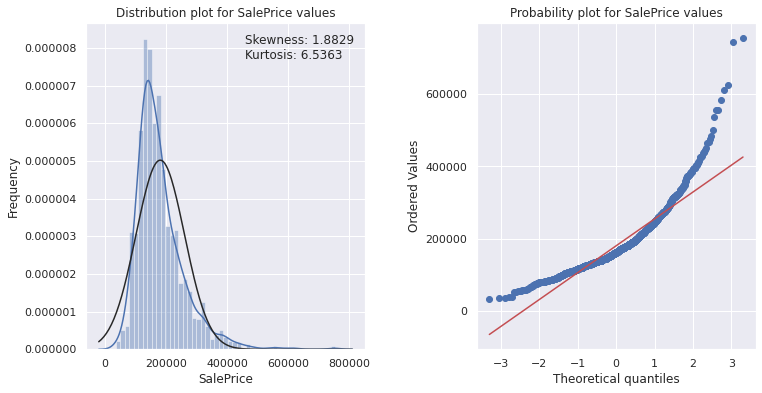

In [181]:
# Making these into functions for use later one

# Generate histogram, and print values for skewness and kurtosis on it
def histogramPlot(var, ax = None, allData = 0):
    p = 0
    if ax is None:
        ax = plt.gca()
        p = 1
        
    if allData == 0:
        df = df_train.copy()
    else:
        df = df_allData.copy()
        
    f = sns.distplot(df[var], fit = norm, ax = ax)
    f.ticklabel_format(style = 'plain', axis = 'y')
    ax.set(title = 'Distribution plot for {} values'.format(var),
            ylabel = 'Frequency')
    ax.add_artist(AnchoredText('Skewness: {:.4f}\nKurtosis: {:.4f}\n'.format(df[var].skew(), df[var].kurt()),
                                loc = 'upper right', frameon = False))
    
    # If not part of a subplot, print the figure
    if p == 1: plt.show()

    
# Generate probability plot (QQ-plot)
def probabilityPlot(var, ax = None, allData = 0):
    p = 0
    if ax is None:
        ax = plt.gca()
        p = 1
        
    if allData == 0:
        df = df_train.copy()
    else:
        df = df_allData.copy()
        
    f = probplot(df[var], plot = plt)
    ax.set(title = 'Probability plot for {} values'.format(var))
    
    # If not part of a subplot, print the figure
    if p == 1: plt.show()


# Print the histogram abd probability plots as a side-by-side subplot
def histAndProbPlot(var, allData = 0):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
    plt.subplots_adjust(wspace = 0.4)
    histogramPlot(var, ax1, allData)
    probabilityPlot(var, ax2, allData)
    plt.show()

    
histAndProbPlot('SalePrice')

Right skew (positive) confirmed. Noted for later, so that I can apply log transformations to normalise SalePrice (and likely other numeric characteristics).

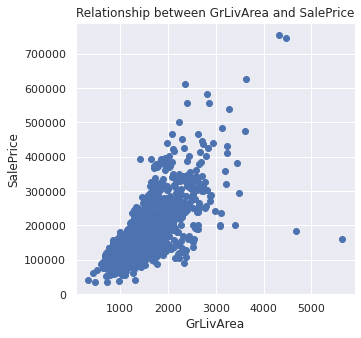

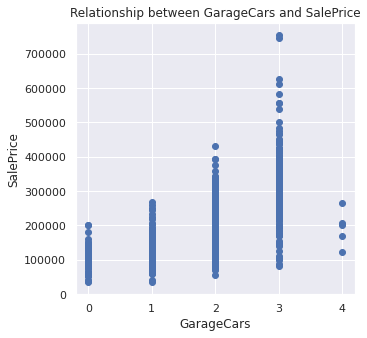

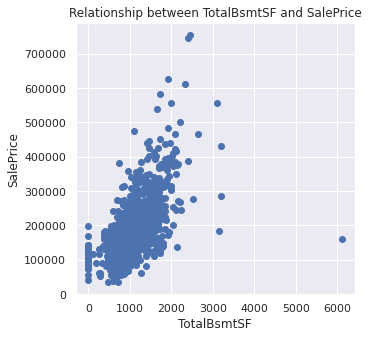

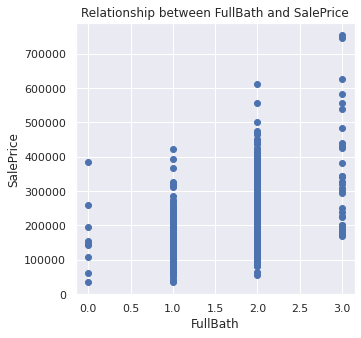

In [182]:
# Making this into a function for use later one
def scatterPlot(xVar, yVar):
    plt.scatter(x = df_train[xVar], y = df_train[yVar])
    plt.title('Relationship between {} and {}'.format(xVar, yVar))
    plt.xlabel(xVar)
    plt.ylabel(yVar)
    plt.show()
    
# Numerical values
variables = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath']
sns.set(font_scale = 1.0, rc = {'figure.figsize': (5, 5)})
for var in variables:
    scatterPlot(var, 'SalePrice')
    
# Categorical variables
#variables = ['OverallQual', 'YearBuilt', 'YearRemodAdd']
#for var in variables:
#    sns.boxplot(x = df_train[var], y = df_train['SalePrice'])
#    plt.title('Relationship between {} and {}'.format(var, 'SalePrice'))
#    plt.xlabel(var)
#    plt.ylabel('SalePrice')
#    plt.xticks(rotation = 90)
#    plt.show()

The relationships are as expected, though there are some outliers to remove. Whilst removing data can be hazardous, GrLivArea and TotalBsmtSF have obvious outliers to the right of the plot, and these will be excluded. However, I'll ignore outliers in characteristics not mentioned above (because their correlation to SalePrice is much lower, their outliers shouldn't have as much negative impact).

In [188]:
# Two outliers within the GrLivArea characteristic
df_train = df_train.drop(df_train[(df_train['GrLivArea'] > 4500) & (df_train['SalePrice'] < 200000)].index)

# One outlier within the TotalBsmtSF characteristic
df_train = df_train.drop(df_train[(df_train['TotalBsmtSF'] > 6000) & (df_train['SalePrice'] < 200000)].index)

df_train.reset_index(drop=True, inplace=True)

## Standardising skewed features

Standardise strongly skewed numerical columns in the dataset using the Box Cox transformation.

The following are the skew values for each numerical column:

Numeric columns with Skew > 0.5 [n = 22]:

MiscVal         21.947
PoolArea        16.898
LotArea         12.822
LowQualFinSF    12.089
3SsnPorch       11.376
KitchenAbvGr     4.302
BsmtFinSF2       4.146
EnclosedPorch    4.004
ScreenPorch      3.947
BsmtHalfBath     3.932
MasVnrArea       2.614
OpenPorchSF      2.535
WoodDeckSF       1.842
LotFrontage      1.506
BsmtFinSF1       1.425
GrLivArea        1.269
TotalBsmtSF      1.157
BsmtUnfSF        0.919
2ndFlrSF         0.862
Fireplaces       0.733
HalfBath         0.695
BsmtFullBath     0.625
dtype: float64


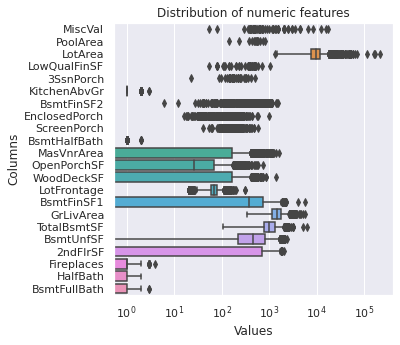

In [184]:
def plotSkewedColumns(numColumns):
    sns.boxplot(data = df_allData[numColumns], orient = 'h')
    plt.title('Distribution of numeric features')
    plt.xlabel('Values')
    plt.ylabel('Columns')
    plt.xscale('log')
    

def printSkewedColumns():
    # Numeric columns
    numColumns = df_allData.dtypes[df_allData.dtypes != 'object'].index

    # Find columns with a strong skew
    skewFlag = 0.5
    skewedColumns = df_allData[numColumns].apply(lambda x: skew(x)).sort_values(ascending = False)
    skewedColumns = skewedColumns[skewedColumns > skewFlag]

    print('Numeric columns with Skew > {} [n = {}]:\n\n{}'.format(skewFlag, len(skewedColumns), skewedColumns))
    
    return skewedColumns

    
sC = printSkewedColumns()
plotSkewedColumns(sC.index)

And applying the Box Cox transform to columns with skew values > 0.5:

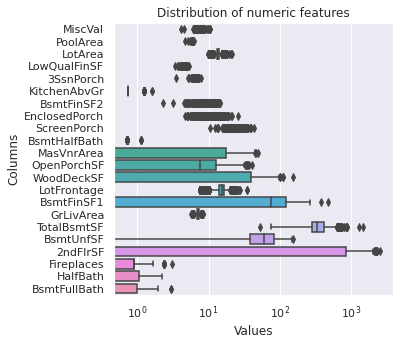

In [185]:
for col in skewedColumns.index:
    df_allData[col] = boxcox1p(df_allData[col], boxcox_normmax(df_allData[col] + 1))
    
plotSkewedColumns(sC.index)

These results aren't perfectly normal, but they are significantly improved.